# Import relevant packages

In [1]:
import numpy as np
from numpy import where, arange, meshgrid, hstack
import pandas as pd
from pandas import read_table, set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from dmba import classificationSummary

from scipy.stats import chi2_contingency

# Load Data

In [2]:
names = ['Category','Currency','sellerRating','Duration','endDay','ClosePrice','OpenPrice','Competitive?']
db = pd.read_excel(r"ebayAuctions.xlsx", names=names, sheet_name='eBay auctions')

In [3]:
data = db.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


# Data Cleansing 

In [5]:
#Convert category, currency, end day, duration variables to dummy variables
db = pd.get_dummies(data=db, columns=['Category','Currency','Duration','endDay']) 

In [6]:
#Calculate spread variable 
db["spread"] = db["ClosePrice"]-db["OpenPrice"]

In [7]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sellerRating                   1972 non-null   int64  
 1   ClosePrice                     1972 non-null   float64
 2   OpenPrice                      1972 non-null   float64
 3   Competitive?                   1972 non-null   int64  
 4   Category_Antique/Art/Craft     1972 non-null   uint8  
 5   Category_Automotive            1972 non-null   uint8  
 6   Category_Books                 1972 non-null   uint8  
 7   Category_Business/Industrial   1972 non-null   uint8  
 8   Category_Clothing/Accessories  1972 non-null   uint8  
 9   Category_Coins/Stamps          1972 non-null   uint8  
 10  Category_Collectibles          1972 non-null   uint8  
 11  Category_Computer              1972 non-null   uint8  
 12  Category_Electronics           1972 non-null   u

# Test/Training Split

In [8]:
#Set X and y 
x=db
y=db.loc[:,"Competitive?"]
X=db.drop(['Competitive?'], axis = 1)

In [9]:
# split off test data using 60/40 split
seed = 42
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# EDA

In [10]:
#Description of numeric variables
sellerRating_des = db['sellerRating'].describe()
ClosePrice_des = db['ClosePrice'].describe()
OpenPrice_des = db['OpenPrice'].describe()
spread_Des = db['spread'].describe()
numeric_variables_des = pd.DataFrame(list(zip(sellerRating_des, ClosePrice_des, OpenPrice_des, spread_Des)), index = ["Count", "mean", "std", "min", "25%", "50%", "75%", "max"] ,columns = ["sellerRating", "ClosePrice", "OpenPrice", "spread"])
numeric_variables_des

,sellerRating,ClosePrice,OpenPrice,spread
Count,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,36.449087,12.926268,23.522819
std,5973.011033,89.493858,38.856149,78.752786
min,0.000000,0.010000,0.010000,0.000000
25%,595.000000,4.907500,1.230000,0.000000
50%,1853.000000,9.995000,4.500000,0.760000
75%,3380.000000,28.000000,9.990000,12.290000
max,37727.000000,999.000000,999.000000,961.010000


<AxesSubplot:>

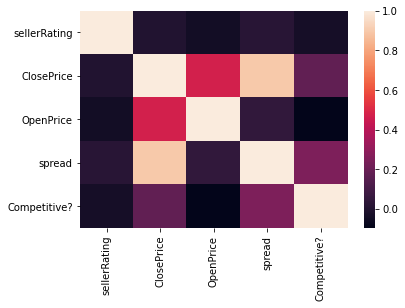

In [11]:
#Correlalgram for numeric variables
numeric_variables = ['sellerRating', "ClosePrice", "OpenPrice", "spread", "Competitive?"]
correlation_matrix = db.loc[:, numeric_variables].corr()
sns.heatmap(correlation_matrix)

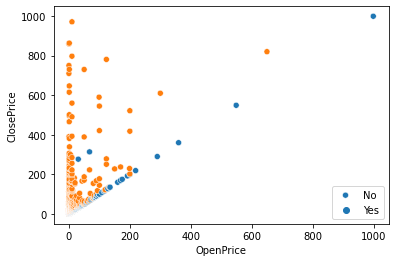

In [12]:
open_close_price = sns.scatterplot(x='OpenPrice', y='ClosePrice', data=db, hue = 'Competitive?')
plt.legend(loc= 'lower right', labels = ['No', 'Yes'])
plt.show(open_close_price)

/Users/shiyi021/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Yes or No')

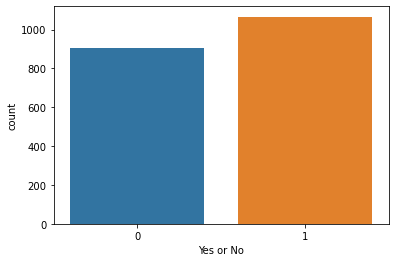

In [13]:
#sns.set_palette('Paired')
competitive_summary = sns.countplot(data['Competitive?'])
competitive_summary.set_xlabel('Yes or No')

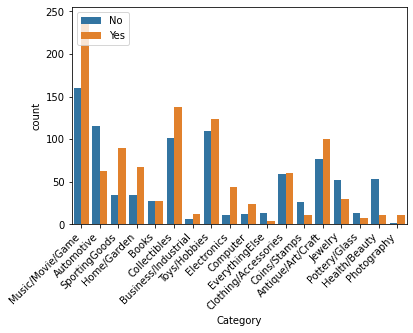

In [14]:
category_plot = sns.countplot(x=data['Category'], hue=data['Competitive?'])
category_plot.set_xticklabels(category_plot.get_xticklabels(), rotation = 45, ha='right')
plt.legend(loc='upper left', labels=['No', 'Yes'])

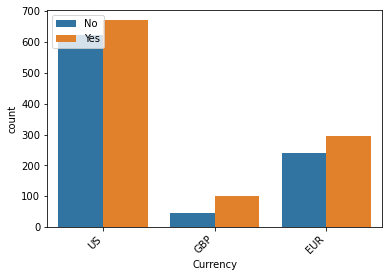

In [15]:
Currency_plot = sns.countplot(x=data['Currency'], hue=data['Competitive?'])
Currency_plot.set_xticklabels(Currency_plot.get_xticklabels(), rotation = 45, ha='right')
plt.legend(loc='upper left', labels=['No', 'Yes'])
plt.show(Currency_plot)

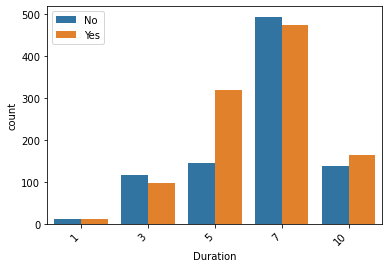

In [16]:
Duration_plot = sns.countplot(x=data['Duration'], hue=data['Competitive?'])
Duration_plot.set_xticklabels(Duration_plot.get_xticklabels(), rotation = 45, ha='right')
plt.legend(loc='upper left', labels=['No', 'Yes'])

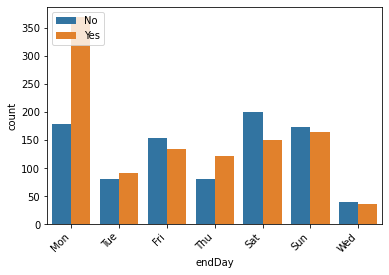

In [17]:
endDay_plot = sns.countplot(x=data['endDay'], hue=data['Competitive?'])
endDay_plot.set_xticklabels(endDay_plot.get_xticklabels(), rotation = 45, ha='right')
plt.legend(loc='upper left', labels=['No', 'Yes'])

### Decision Tree with All features

In [18]:
# Create the Decision Tree
fulltree = DecisionTreeClassifier(min_samples_leaf=50, random_state = 1)
fulltree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=1)

In [19]:
# Model Evaluation
y_predicted = fulltree.predict(X_test)
print(fulltree.score(X_test, y_test))
confusion_matrix = classificationSummary(y_test, y_predicted)
confusion_matrix

0.9455006337135615
Confusion Matrix (Accuracy 0.9455)

       Prediction
Actual   0   1
     0 333  26
     1  17 413


In [20]:
export_graphviz(fulltree, out_file='fullClassTree.dot', feature_names=X_train.columns)

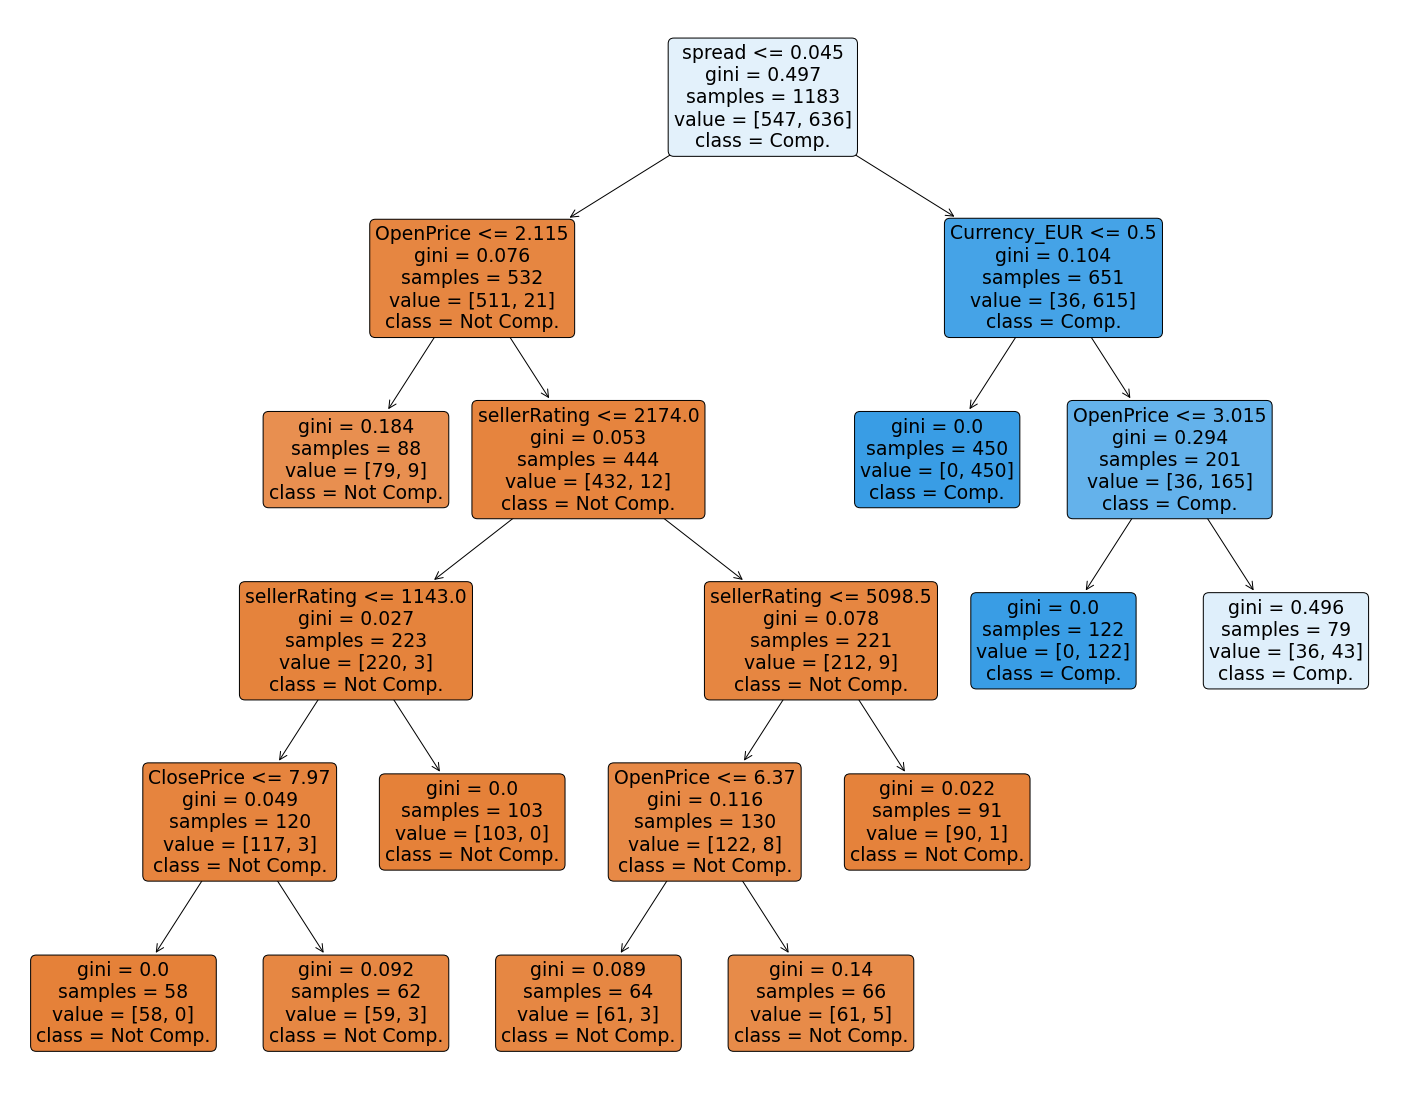

In [21]:
fig = plt.figure(figsize=(25, 20))
_=plot_tree(fulltree,
            feature_names=X_train.columns,
            class_names=['Not Comp.','Comp.'],
            filled=True,
            rounded = True)
plt.savefig('fullClassTree')

### Decision Tree with Reduced Set of Features

#### Slightly fewer number of predictors

In [22]:
smalltree = DecisionTreeClassifier(min_samples_leaf=50, max_features=4, random_state=1)
smalltree.fit(X_train, y_train)
y_predicted = smalltree.predict(X_test)
print(smalltree.score(X_test, y_test))
confusion_matrix = classificationSummary(y_test, y_predicted)
confusion_matrix

0.9455006337135615
Confusion Matrix (Accuracy 0.9455)

       Prediction
Actual   0   1
     0 333  26
     1  17 413


In [23]:
export_graphviz(smalltree, out_file='SmallerTree.dot', feature_names=X_train.columns)

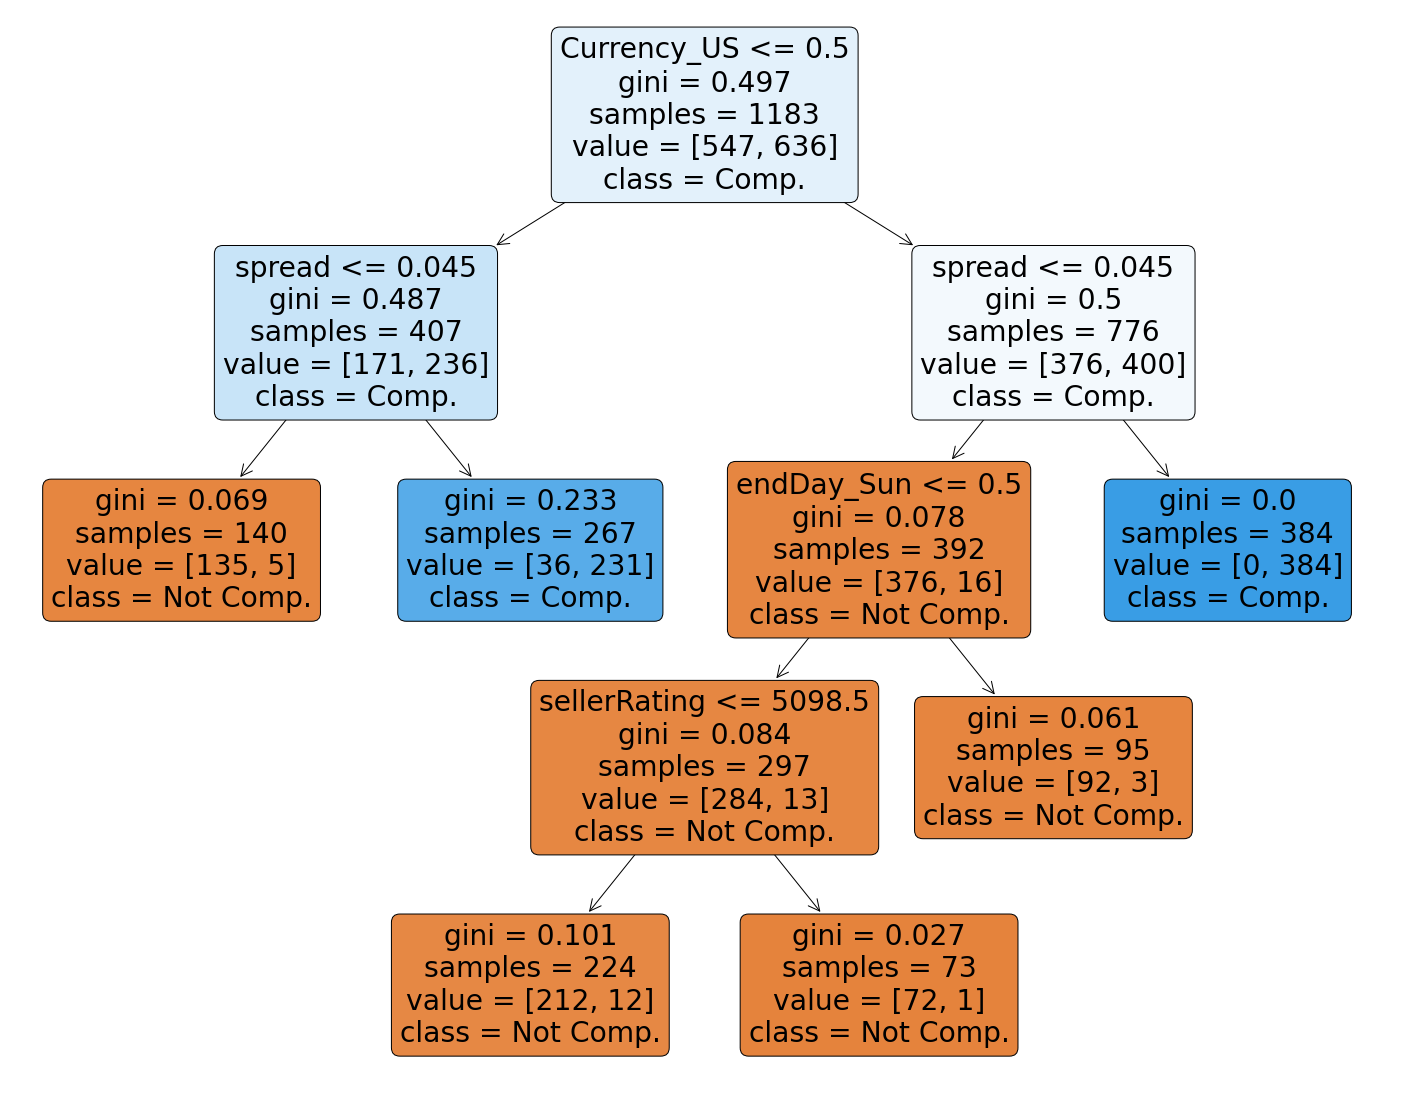

In [24]:
fig = plt.figure(figsize=(25, 20))
_=plot_tree(smalltree,
            feature_names=X_train.columns,
            class_names=['Not Comp.','Comp.'],
            filled=True,
            rounded = True)
plt.savefig('SmallerTree')

#### Classification Tree without irrelevant variables 

In [25]:
features_drop = ["ClosePrice", "spread"]
X_train1 = X_train.drop(features_drop, axis = 1)
X_test1 = X_test.drop(features_drop, axis = 1)

smalltree2 = DecisionTreeClassifier(min_samples_leaf=50, random_state=1)
smalltree2.fit(X_train1, y_train)
y_predicted = smalltree2.predict(X_test1)
print(smalltree2.score(X_test1, y_test))
confusion_matrix = classificationSummary(y_test, y_predicted)
confusion_matrix

0.7110266159695817
Confusion Matrix (Accuracy 0.7110)

       Prediction
Actual   0   1
     0 233 126
     1 102 328


In [26]:
export_graphviz(smalltree2, out_file='AnotherClassificationTree.dot', feature_names=X_train1.columns)

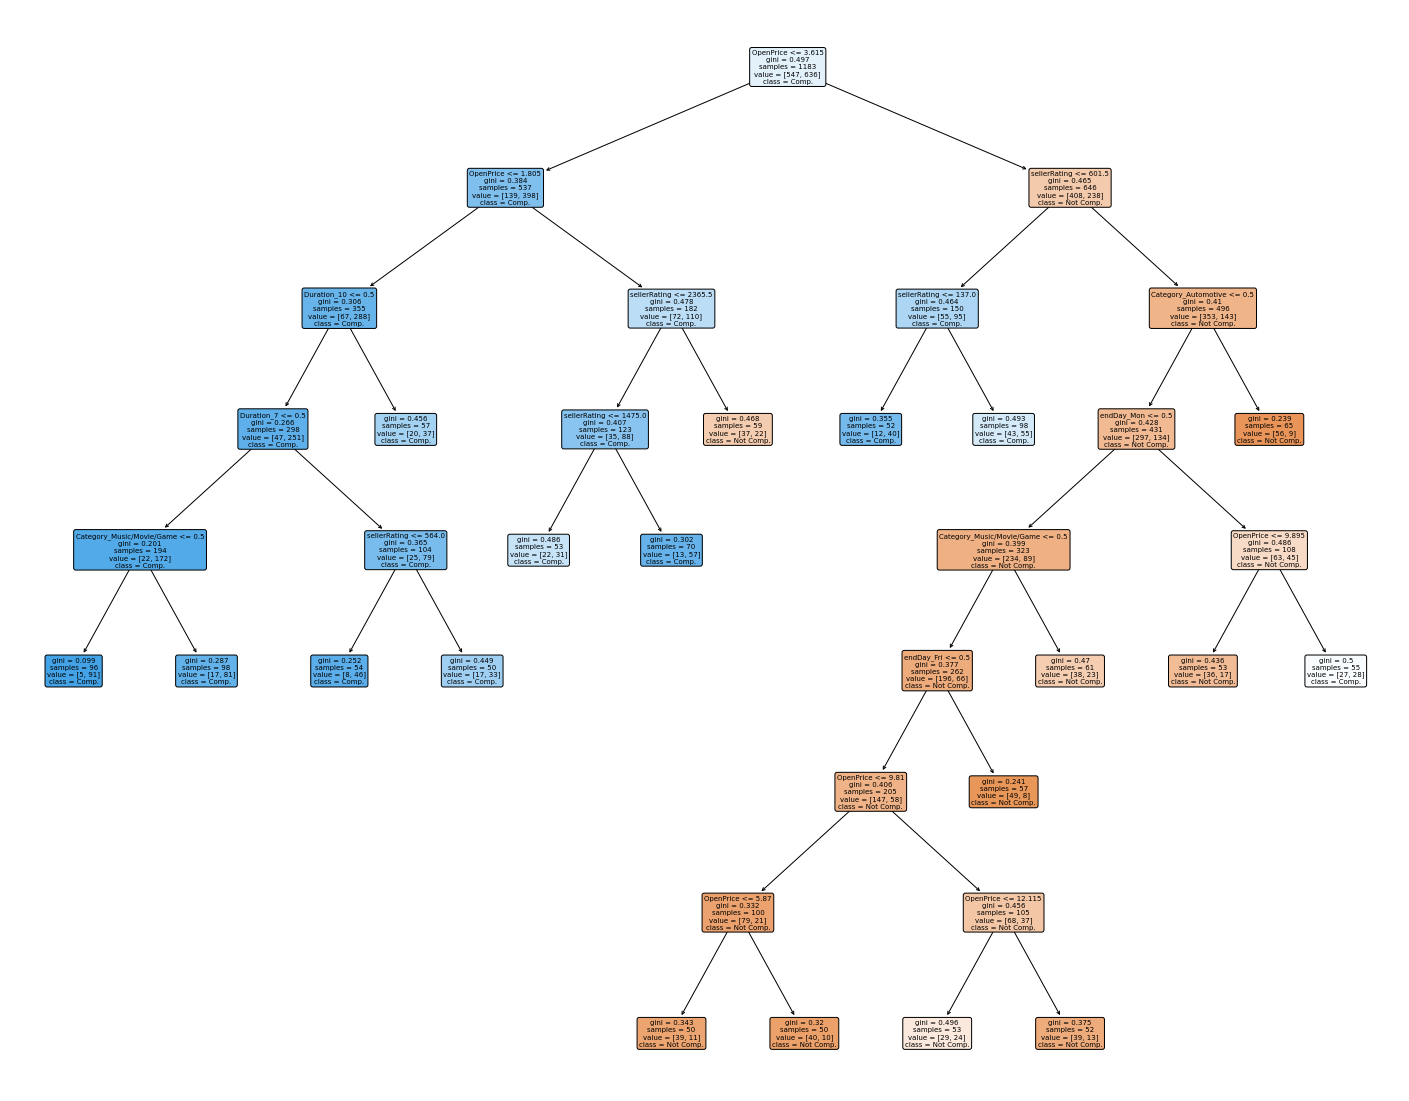

In [27]:
fig = plt.figure(figsize=(25, 20))
_=plot_tree(smalltree2,
            feature_names=X_train1.columns,
            class_names=['Not Comp.','Comp.'],
            filled=True,
            rounded = True)

#### Visualizing the Importance of Each Feature

<AxesSubplot:xlabel='Variable Names', ylabel='Gini Importance'>

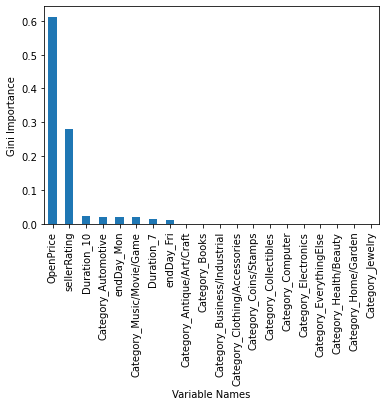

In [33]:
feat_importances = pd.Series(smalltree2.feature_importances_, index=X_train1.columns)
feat_importances.nlargest(20).plot(kind='bar',
                                   ylabel = "Gini Importance",
                                   xlabel = "Variable Names")


### Visualizing Decision Surface

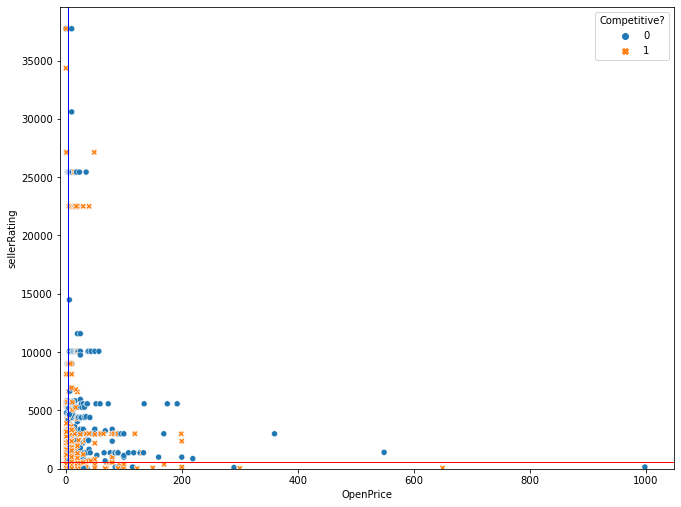

In [29]:
fig, ax = plt.subplots(figsize=(11, 8.5))
g = sns.scatterplot(x='OpenPrice', y='sellerRating', data=db, ax=ax, hue = "Competitive?", style = "Competitive?")
g.set(xlim=(-10, None), ylim = (-10, None))
ax.axvline(x=3.615, color='blue', linewidth=1)
ax.axhline(y=601.5, color='red', linewidth=1) 

#### Optimal Tree

In [30]:
selected_features = ["OpenPrice", "sellerRating"]
X_train2 = X_train.loc[:, selected_features]
X_test2 = X_test.loc[:, selected_features]

optimal_tree= DecisionTreeClassifier(min_samples_leaf=50, random_state=1)
optimal_tree.fit(X_train2, y_train)
y_predicted = optimal_tree.predict(X_test2)
print(optimal_tree.score(X_test2, y_test))
confusion_matrix = classificationSummary(y_test, y_predicted)
confusion_matrix

0.7097591888466414
Confusion Matrix (Accuracy 0.7098)

       Prediction
Actual   0   1
     0 251 108
     1 121 309


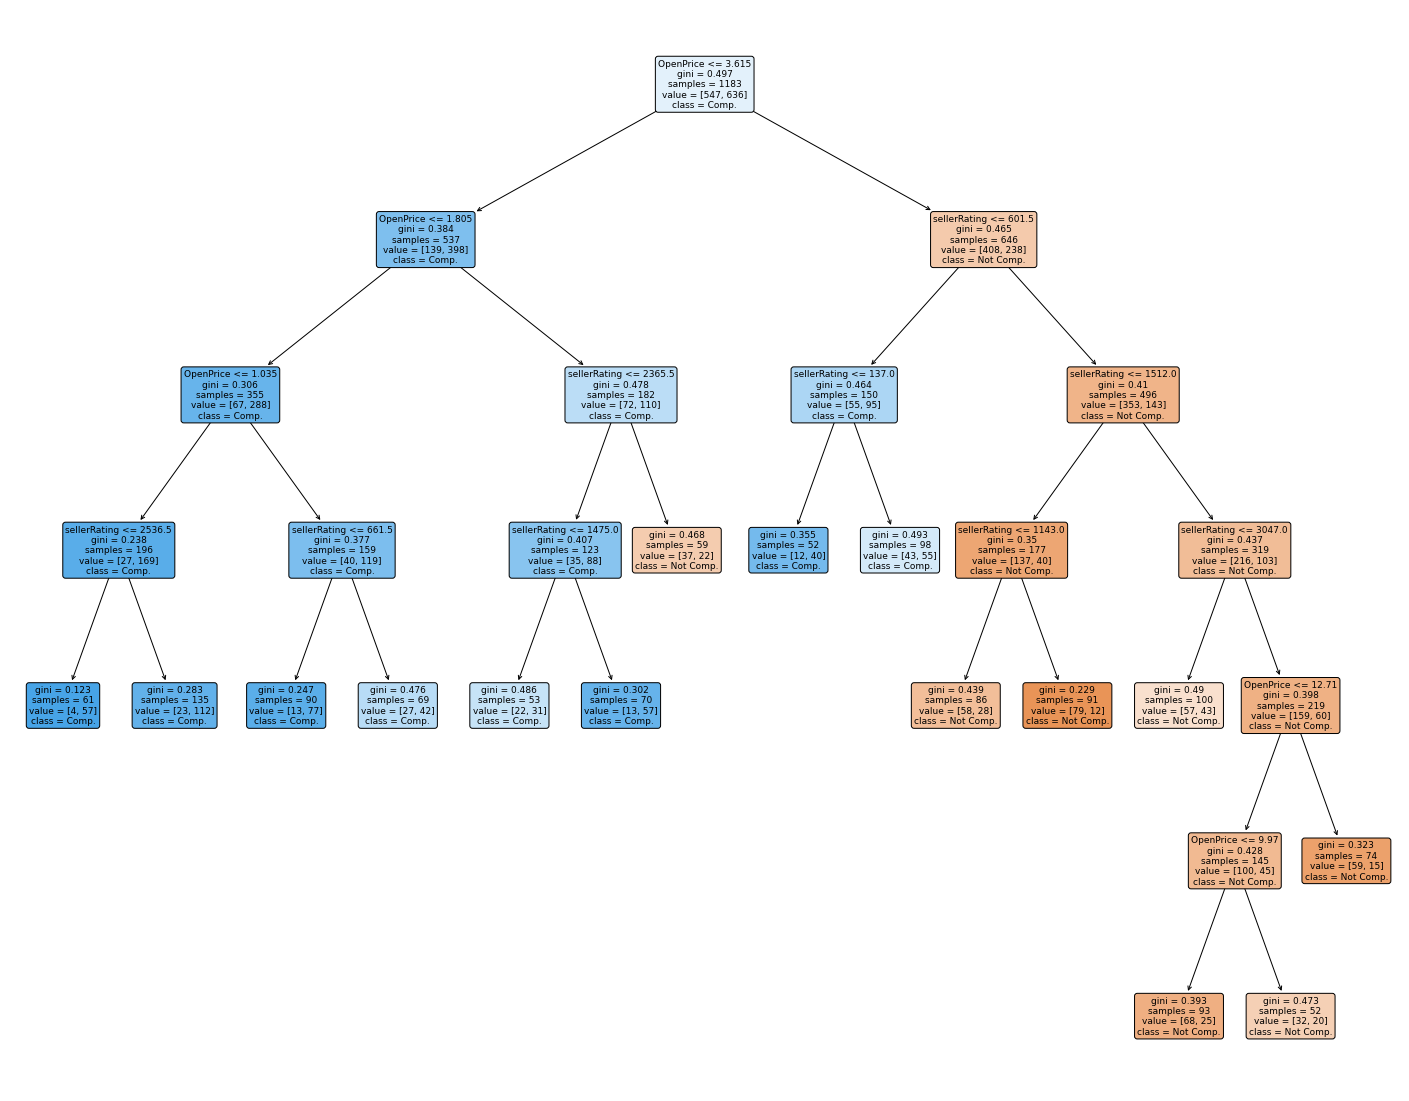

In [32]:
fig = plt.figure(figsize=(25, 20))
_=plot_tree(optimal_tree,
            feature_names=X_train2.columns,
            class_names=['Not Comp.','Comp.'],
            filled=True,
            rounded = True)